# 04 - Deploying model

The final notebook in the series is dedicated to model deployment and evaluation. It outlines the steps taken to load the trained model and apply it to classify new images from the test dataset. Key aspects include:

- Loading the Saved Model: It begins with loading the model saved during the training process, ensuring that it retains its learned weights and biases.

- Image Classification: The notebook demonstrates how to classify new images using the loaded model. This step is crucial for assessing the model's practical applicability and performance on unseen data.

- New Image Processing: Detailed instructions are provided on selecting and preprocessing images from the test dataset to ensure they are in the correct format for classification by the model.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from mypackages.landneuralnetwork import LandClassifierNet

# Preparing environment and variables

In [2]:
# Destination folders for training and testing image groups
train_images_folder = "../data/train_imgs"
test_images_folder = "../data/test_imgs"

In [3]:
# Data transformations
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Training dataset
train_dataset = torchvision.datasets.ImageFolder(root = train_images_folder, transform = transform)
# Testing dataset
test_dataset = torchvision.datasets.ImageFolder(root = test_images_folder, transform = transform)
# Training Dataloader
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 2)
# Testing Dataloader
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True, num_workers = 2)

In [4]:
mapping = {0:'AnnualCrop',
              1:'Forest',
              2:'HerbaceousVegetation',
              3:'Highway',
              4:'Industrial',
              5:'Pasture',
              6:'PermanentCrop',
              7:'Residential',
              8:'River',
              9:'SeaLake'}

# Loading model

In [5]:
# Initialize the model structure
nn_model = LandClassifierNet()  

# Then load the saved state_dict
nn_model.load_state_dict(torch.load('nn_model.pth'))

# Call model.eval() to set dropout and batch normalization layers to evaluation mode
nn_model.eval()

LandClassifierNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Send model to device
nn_model.to(device)

cuda:0


LandClassifierNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

# Deploy model - Classify image

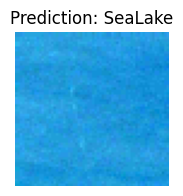

In [22]:
# Puts the model in evaluation mode
with torch.no_grad():

    # Gets the first batch of data
    dataiter = iter(test_dl)
    data = next(dataiter)

    # Retrieves the inputs (images)
    inputs, _ = data

    # Selects the first image from the batch
    image = inputs[0].unsqueeze(0)

    # Moves the image to the same device as the model
    image = image.to(device)

    # Gets the model's prediction for this image
    outputs = nn_model(image)

    # Retrieves the index of the predicted class
    _, predicted = torch.max(outputs, 1)

    # Converts the image to a numpy format for visualization
    # Moves the image back to CPU and converts it to numpy
    image_numpy = image.cpu().numpy()[0]

    # Images are typically in [C, H, W] format, so you need to reorder them to [H, W, C] for visualization
    # This also depends on the image data type; you might need to normalize or adjust the range for correct visualization
    image_numpy = np.transpose(image_numpy, (1, 2, 0))

    # Adjusts the image channels if necessary (e.g., if it's in grayscale or if normalization was applied)
    if image_numpy.shape[2] == 1:  # Grayscale images
        image_numpy = np.squeeze(image_numpy, axis=2)
    elif image_numpy.shape[2] == 3:  # RGB images
        # Normalizes to 0-1 range if necessary
        image_numpy = (image_numpy - image_numpy.min()) / (image_numpy.max() - image_numpy.min())

    plt.figure(figsize=(2, 2))
    plt.imshow(image_numpy)
    plt.title(f'Prediction: {mapping[predicted.item()]}')
    plt.axis('off')
    plt.show()
